# 1. Build an object detection model using pytorch

In [2]:
import os
import io
import random
import numpy as np
import pandas as pd

import cv2

import matplotlib.pyplot as plt
import matplotlib.patches as patches

import torch
import torchvision
import torch.nn as nn
import torchvision.transforms as transforms
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import random_split
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, models, transforms
from PIL import Image

from sklearn.model_selection import train_test_split

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
%cd /content/drive/My\ Drive/Project2_CV/cowstall

/content/drive/My Drive/Project2_CV/cowstall


In [5]:
!ls

 gnet_100.pt   gnet_20.pt  'Project2_CV_Lakshmikar Reddy P.ipynb'   test_
 gnet_10.pt    gnet_25.pt  'Project Two_trial.ipynb'		    train_
 gnet_120.pt   gnet_50.pt  'Project Two_V1.ipynb'		    v3_20.pt
 gnet_140.pt   gnet_80.pt   Stall_num_images


In [6]:

# Reading train images details

df_train = pd.read_csv('https://raw.githubusercontent.com/YoushanZhang/Cow_stall_number/main/Train.csv')
df_train.fillna(0, inplace=True)
df_train.head()

,imageFilename,box_position_1,box_position_2,box_position_3,box_position_4,class_names
0,GH030066_4679.png,287.0,116.0,25.0,23.0,29
1,GH020058_19383.png,275.0,58.0,23.0,24.0,44
2,GH030061_1269.png,306.0,74.0,26.0,25.0,13
3,GH020058_17235.png,0.0,0.0,0.0,0.0,0
4,GH020058_18319.png,288.0,55.0,23.0,23.0,42


In [7]:
train_set, val_set = train_test_split(df_train, test_size=0.12, random_state=42, shuffle=True)
print(len(train_set))
print(len(val_set))

916
126


In [34]:
trans = transforms.Compose([
        #transforms.RandomResizedCrop(299),
        #transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])

In [35]:
test_trans = transforms.Compose([
        #transforms.RandomResizedCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])

In [36]:
# Creating dataset

class CowstallDataset(Dataset):
    
    def __init__(self, dataframe, root_dir, transform = None):
      super().__init__()

      #self.image_ids = dataframe['imageFilename'].unique()
      self.dataframe = dataframe
      self.root_dir = root_dir
      self.transform = transform
       
            
    def __len__(self):
      return len(self.dataframe)

    def __getitem__(self, idx):

      #image_id = self.image_ids[idx]
        
      image_path = os.path.join(self.root_dir, self.dataframe.iloc[idx,0])
      image = cv2.imread(image_path,cv2.IMREAD_UNCHANGED)
      #image = Image.open(image_path)
      image = cv2.resize(image, (299,299))
      image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
      image /= 255.0
      image = self.transform(image)
      
      labels = torch.tensor(int(self.dataframe.iloc[idx,5]))

      boxes = self.dataframe[['box_position_1', 'box_position_2', 'box_position_3', 'box_position_4']].values[idx]
      boxes[2] = boxes[0] + boxes[2]
      boxes[3] = boxes[1] + boxes[3]
      boxes = torch.as_tensor(boxes, dtype=torch.float32)

      return image, labels, boxes 
        

In [37]:
# Data Loading

root_dir = './Stall_num_images/Stall_num_images'

train_dataset = CowstallDataset(train_set, root_dir, trans)
valid_dataset = CowstallDataset(val_set, root_dir, trans)

train_data_loader = DataLoader(
    train_dataset,
    batch_size=16,
    shuffle=False,
    #num_workers=4,
)

valid_data_loader = DataLoader(
    valid_dataset,
    batch_size=16,
    shuffle=False,
    #num_workers=4,
)


In [38]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

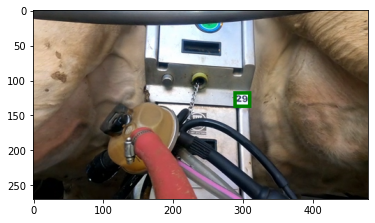

In [39]:
# Draw a bounding box on an image for checking

# Import the required libraries
from torchvision.io import read_image
from torchvision.utils import draw_bounding_boxes
  
# read input image
img = read_image('Stall_num_images/Stall_num_images/GH030066_4679.png')

# bounding box are xmin, ymin, xmax, ymax
bbox = [287, 116, 312, 139]
bbox = torch.tensor(bbox)
bbox = bbox.unsqueeze(0)
  
# draw bounding box and fill color
img = draw_bounding_boxes(img, bbox, width=5,
                          colors="green")
  
# transform this image to PIL image
img = torchvision.transforms.ToPILImage()(img)
  
# display output
#img.show()
plt.imshow(img)

In [45]:
class ObjectDetection(nn.Module):
    def __init__(self):
        super(ObjectDetection, self).__init__()
        
        self.google_net = torchvision.models.googlenet(pretrained=True)

        self.google_net_fe = nn.Sequential(*list(self.google_net.children())[:-1])

        self.flatten = nn.Flatten()

        self.classifier = nn.Sequential(nn.Linear(1000,61))

        self.bbox = nn.Sequential(nn.Linear(1000,4))
        

    def forward(self, x):
        # print(x.shape)  
        x = self.google_net(x)
        # print(x.shape)
        x = self.flatten(x)
        x_c = F.log_softmax(self.classifier(x), dim=1)
        x_c = self.classifier(x)
        # print(x_c.shape)
       
        x_b = self.bbox(x)
        # print(x_b.shape)


        return x_c, x_b

In [126]:
#model = ObjectDetection().to(device)
model = torch.load('gnet_200.pt')

# 2. Train your model using cow stall number datasets

In [109]:
#Loss functions

criterion_1 = nn.CrossEntropyLoss()
criterion_2 = nn.MSELoss()

In [110]:
def update_optimizer(optimizer, lr):
    for i, param_group in enumerate(optimizer.param_groups):
        param_group["lr"] = lr

In [111]:
params = [p for p in model.parameters() if p.requires_grad]

In [112]:
# Optimizer
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

In [113]:
# lr_scheduler = torch.optim.lr_scheduler.StepLR(
#   optimizer,
#   step_size=3,
#   gamma=0.001
# )

In [127]:
update_optimizer(optimizer, 0.001)
epochs = 10
train_losses = []
for e in range(epochs):
    running_loss = 0
    for images, labels, boxes in train_data_loader:
               
        # Training pass

        outputs = model(images.to(device))

        loss1 = criterion_1(outputs[0], labels.to(device))
        loss2 = torch.sqrt(criterion_2(outputs[1], boxes.to(device)))*0.01
        # print("loss1:", loss1)
        # print("loss2:", loss2)
        # break
        loss = loss1+loss2
   
        optimizer.zero_grad()

        loss.backward()

        optimizer.step()
        #lr_scheduler.step()

        running_loss += loss.item()        
       
    # validation accuracy
    correct = 0
    total = 0
    with torch.no_grad():
        for data in valid_data_loader:
            X,y,z = data
            outputs = model(X.to(device))
            for idx, i in enumerate(outputs[0]):
                if torch.argmax(i) == y[idx]:
                    correct += 1
                total += 1

    print(f"Epoch {e+1}/{epochs}, Training loss: {running_loss/len(train_data_loader)}, Validation Accuracy: {round(correct/total,3)}")
    train_losses.append(running_loss/len(train_data_loader))

#torch.save(model,'gnet_200.pt')


Epoch 1/10, Training loss: 1.9019526510403073, Validation Accuracy: 0.405
Epoch 2/10, Training loss: 1.901699995172435, Validation Accuracy: 0.413
Epoch 3/10, Training loss: 1.901556937858976, Validation Accuracy: 0.46
Epoch 4/10, Training loss: 1.9015993496467327, Validation Accuracy: 0.413
Epoch 5/10, Training loss: 1.9019251301370819, Validation Accuracy: 0.413
Epoch 6/10, Training loss: 1.9019436240196228, Validation Accuracy: 0.397
Epoch 7/10, Training loss: 1.901854040293858, Validation Accuracy: 0.405
Epoch 8/10, Training loss: 1.9017699730807338, Validation Accuracy: 0.421
Epoch 9/10, Training loss: 1.9021868644089535, Validation Accuracy: 0.429
Epoch 10/10, Training loss: 1.9021483125357792, Validation Accuracy: 0.421


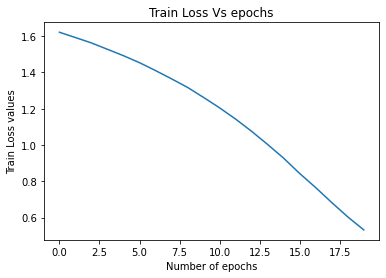

In [117]:
e = [i for i in range(0,20)]
plt.plot(e, train_losses), plt.title('Train Loss Vs epochs'), plt.xlabel('Number of epochs'), plt.ylabel('Train Loss values')
plt.show()

# 3.Evaluate your model using the test images

In [89]:
df_test = pd.read_csv('https://raw.githubusercontent.com/YoushanZhang/Cow_stall_number/main/Test.csv')
df_test.fillna(0, inplace=True)
df_test.head()

,imageFilename,box_position_1,box_position_2,box_position_3,box_position_4,class_names
0,GH030061_12040.png,172.0,81.0,25.0,24.0,28
1,GH030072_2783.png,289.0,94.0,23.0,21.0,42
2,GH010059_45.png,0.0,0.0,0.0,0.0,0
3,GH030072_4929.png,288.0,94.0,23.0,23.0,46
4,GH020072_31411.png,0.0,0.0,0.0,0.0,0


In [73]:
len(df_test)

261

In [74]:
test_trans = transforms.Compose([transforms.ToTensor()])

In [75]:
root_dir = './Stall_num_images/Stall_num_images'

test_dataset = CowstallDataset(df_test, root_dir, test_trans)

test_data_loader = DataLoader(
    test_dataset,
    batch_size=261,
    shuffle=False,
    #num_workers=4,
)

# 4. Your results can be higher than 90%.

In [129]:
# Accuracy in predcting stall numbers

correct = 0
total = 0

with torch.no_grad():
    for data in test_data_loader:
        X,y,z = data
        outputs = model(X.to(device))
        bbox_array = outputs[1].cpu().numpy()
        bbox_df = pd.DataFrame(bbox_array, columns = ['Pos1','Pos2','Pos3','Pos4'])
        print(bbox_df)
        for idx, i in enumerate(outputs[0]):
            if torch.argmax(i) == y[idx]:
                correct += 1
            total += 1
print("Test Accuracy for stall numbers in percentage: ", round(100*correct/total, 3))

          Pos1      Pos2       Pos3      Pos4
0     1.663297  0.898253   1.198033  1.831992
1    10.881936  4.685533  12.525953  3.306671
2     1.598484  1.836103   2.348116  1.158137
3     9.637151  2.893028  11.821299  5.080576
4     6.540452  2.544199   7.003230  1.939355
..         ...       ...        ...       ...
256   7.140409  2.314199   8.750319  2.970275
257   9.893294  3.145056  11.553802  4.447781
258   8.965682  3.609162   9.964161  2.944838
259   3.020577  1.091155   4.376898  0.541325
260  11.316911  4.597389  13.214764  3.986479

[261 rows x 4 columns]
Test Accuracy for stall numbers in percentage:  45.211


# 5. Optional: write a four-page report using LaTex and upload your paper to ResearchGate or Arxiv. Extra: 10 points 
